# Эксперимент с базовыми моделями

In [141]:
import matplotlib.pyplot as plt
import tensorly
import nibabel
import numpy as np
from scipy.fftpack import dctn, idctn

In [2]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, dim, mode):
    index = list()
    index.append(mode)
    for i in range(dim.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(dim[index]), order = 'F'), 0, mode)

def svt(mat, tau):
    u, s, v = np.linalg.svd(mat, full_matrices = False)
    vec = s - tau
    vec[vec < 0] = 0
    return np.matmul(np.matmul(u, np.diag(vec)), v)
    
def svt_tsn(mat, tau, p, theta, sv):
    tau = p * np.power(sv, p - 1) * tau
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    vec = s.copy()
    vec[theta :] = s[theta :] - tau[theta :]
    vec[vec < 0] = 0
    return u @ np.diag(vec) @ v, s

def tsvt_tnn(tensor, tau):
    dim = tensor.shape
    X = np.zeros(dim)
    tensor = dctn(tensor, axes = (2, ), norm = 'ortho')
    for t in range(dim[2]):
        u, s, v = np.linalg.svd(tensor[:, :, t], full_matrices = False)
        s = s - tau
        s[s < 0] = 0
        X[:, :, t] = u @ np.diag(s) @ v
    return idctn(X, axes = (2, ), norm = 'ortho')
    
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

In [3]:
def TNN_DCT(dense_tensor, sparse_tensor, rho0, epsilon, maxiter):
    """TNN-DCT-imputer."""
    dim = np.array(sparse_tensor.shape)
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))

    T = np.zeros(dim)                         # \boldsymbol{\mathcal{T}}
    Z = sparse_tensor.copy()                     # \boldsymbol{Z}
    Z[pos_missing] = np.mean(sparse_tensor[sparse_tensor != 0])
    it = 0
    last_ten = sparse_tensor.copy()
    snorm = np.linalg.norm(sparse_tensor)
    rho = rho0
    while True:
        rho = min(rho * 1.05, 1e5)
        X = tsvt_tnn(Z - T / rho, 1 / rho)
        temp2 = rho * X + T
        Z[pos_missing] = temp2[pos_missing] / rho
        T = T + rho * (X - Z)
        tol = np.linalg.norm((X - last_ten)) / snorm
        last_ten = X.copy()
        it += 1
        
        if (tol < epsilon) or (it >= maxiter):
            break
            
    return X

In [4]:
def HaLRTC(dense_tensor, sparse_tensor, alpha: list, rho: float, epsilon: float, maxiter: int):
    dim = np.array(sparse_tensor.shape)
    tensor_hat = sparse_tensor
    pos_missing = np.where(sparse_tensor == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    B = [np.zeros(sparse_tensor.shape) for _ in range(len(dim))]
    Y = [np.zeros(sparse_tensor.shape) for _ in range(len(dim))]
    last_ten = sparse_tensor.copy()
    snorm = np.linalg.norm(sparse_tensor)
    
    it = 0
    while True:
        for k in range(len(dim)):
            B[k] = mat2ten(svt(ten2mat(tensor_hat + Y[k] / rho, k), alpha[k] / rho), dim, k)
        tensor_hat[pos_missing] = ((sum(B) - sum(Y) / rho) / 3)[pos_missing]
        for k in range(len(dim)):
            Y[k] = Y[k] - rho * (B[k] - tensor_hat)
        tol = np.linalg.norm((tensor_hat - last_ten)) / snorm
        last_ten = tensor_hat.copy()
        it += 1
        # if it % 1 == 0:
        #     print('Iter: {}'.format(it))
        #     print('Tolerance: {:.6}'.format(tol))
        #     print('MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
        #     print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
        #     print()
        if (tol < epsilon) or (it >= maxiter):
            break
    
    # print('Total iteration: {}'.format(it))
    # print('Tolerance: {:.6}'.format(tol))
    # print('MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
    # print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
    # print()
    
    return tensor_hat

In [5]:
def LATC(dense_tensor, sparse_tensor, time_lags, alpha, rho0, lambda0, p, theta, epsilon, maxiter):
    """Low-Rank Autoregressive Tensor Completion, LATC-imputer."""
    dim = np.array(sparse_tensor.shape)
    dim_time = int(np.prod(dim) / dim[0])
    d = len(time_lags)
    max_lag = np.max(time_lags)
    sparse_mat = ten2mat(sparse_tensor, 0)
    pos_missing = np.where(sparse_mat == 0)
    pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
    
    X = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{X}}
    T = np.zeros(np.insert(dim, 0, len(dim))) # \boldsymbol{\mathcal{T}}
    Z = sparse_mat.copy()                     # \boldsymbol{Z}
    Z[pos_missing] = np.mean(sparse_mat[sparse_mat != 0])
    A = 0.001 * np.random.rand(dim[0], d)     # \boldsymbol{A}
    it = 0
    sv = []
    for k in range(len(dim)):
        _, s, _ = np.linalg.svd(ten2mat(sparse_tensor, k), full_matrices = 0)
        sv.append(s)
    ind = np.zeros((d, dim_time - max_lag), dtype = np.int_)
    for i in range(d):
        ind[i, :] = np.arange(max_lag - time_lags[i], dim_time - time_lags[i])
    last_mat = sparse_mat.copy()
    snorm = np.linalg.norm(sparse_mat, 'fro')
    rho = rho0
    while True:
        rho = min(rho * 1.05, 1e5)
        for k in range(len(dim)):
            temp, sv0 = svt_tsn(ten2mat(mat2ten(Z, dim, 0) - T[k] / rho, k), alpha[k] / rho, p, theta, sv[k])
            X[k] = mat2ten(temp, dim, k)
            sv[k] = sv0
        tensor_hat = np.einsum('k, kmnt -> mnt', alpha, X)
        mat_hat = ten2mat(tensor_hat, 0)
        mat0 = np.zeros((dim[0], dim_time - max_lag))
        if lambda0 > 0:
            for m in range(dim[0]):
                Qm = mat_hat[m, ind].T
                A[m, :] = np.linalg.pinv(Qm) @ Z[m, max_lag :]
                mat0[m, :] = Qm @ A[m, :]
            mat1 = ten2mat(np.mean(rho * X + T, axis = 0), 0)
            Z[pos_missing] = np.append((mat1[:, : max_lag] / rho), (mat1[:, max_lag :] + lambda0 * mat0) 
                                       / (rho + lambda0), axis = 1)[pos_missing]
        else:
            Z[pos_missing] = (ten2mat(np.mean(X + T / rho, axis = 0), 0))[pos_missing]
        T = T + rho * (X - np.broadcast_to(mat2ten(Z, dim, 0), np.insert(dim, 0, len(dim))))
        tol = np.linalg.norm((mat_hat - last_mat), 'fro') / snorm
        last_mat = mat_hat.copy()
        it += 1
        # if it % 100 == 0:
        #     print('Iter: {}'.format(it))
        #     print('Tolerance: {:.6}'.format(tol))
        #     print('MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
        #     print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
        #     print()
        if (tol < epsilon) or (it >= maxiter):
            break

    # print('Total iteration: {}'.format(it))
    # print('Tolerance: {:.6}'.format(tol))
    # print('Imputation MAPE: {:.6}'.format(compute_mape(dense_tensor[pos_test], tensor_hat[pos_test])))
    # print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], tensor_hat[pos_test])))
    # print()
    
    return tensor_hat

In [155]:
def TuckerTC(
    dense_tensor,
    random_tensor,
    ranks: list,
    maxiter: int
):

    T = dense_tensor.copy()
    Q = np.round(random_tensor + 0.5 - missing_rate)
    _Q = (Q!=1).astype(int)
    
    G, U_s = tensorly.decomposition.tucker(dense_tensor, ranks )
    tensor_hat_simple_tucker = tensorly.tucker_to_tensor((G, U_s))
    
    it = 0
    while True:
        X = tensorly.tucker_to_tensor((G, U_s))
        Z = np.multiply(Q, T) + np.multiply(_Q, X)
        for i in range(len(G.shape)):
            U_s_T = [elem.T for elem in U_s]
            U_s_T[i] = tensorly.eye(U_s_T[i].shape[1])
            Y = tensorly.tucker_to_tensor((Z, U_s_T))
            U, _, _ = tensorly.tenalg.svd_interface(tensorly.unfold(Y, mode=i), n_eigenvecs = ranks[i])
            U_s[i] = U
            
        U_s_T = [elem.T for elem in U_s]    
        G = tensorly.tucker_to_tensor((Z, U_s_T))
    
        it += 1
        if it == maxiter:
            break
    
    tensor_hat = tensorly.tucker_to_tensor((G, U_s))
    return tensor_hat

In [156]:
# import numpy as np
# import scipy.io

# def signaltonoise(a, axis=0, ddof=0):
#     a = np.asanyarray(a)
#     m = a.mean(axis)
#     sd = a.std(axis=axis, ddof=ddof)
#     return np.where(sd == 0, 0, m/sd)

# dat = scipy.io.loadmat('./data.mat')
# arr = dat['dn']
# snr = signaltonoise(arr)

In [157]:
data = nibabel.load('./../data/MoAEpilot/sM00223/sM00223_002.hdr').get_fdata()
data = np.rot90(data.squeeze(), 1)

In [158]:
dense_tensor = data.copy()
dense_tensor[:,:,13:15] = 0

### Random missing (RM) scenario:
random_tensor = np.random.rand(256, 256, 54)
missing_rate = 0.0
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [142]:
# tol = np.linalg.norm((tensor_hat - last_ten)) / snorm
# last_ten = tensor_hat.copy()

In [178]:
dense_tensor = data.copy()
dense_tensor[:,:,13:15] = 0

### Random missing (RM) scenario:
random_tensor = np.random.rand(256, 256, 54)
missing_rate = 0.0
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

maxiter = 100
L_ranks = [np.arange(10,200,10),np.arange(10,200,10),[5,6,7,8,10,15,25,30]]

In [179]:
# def TuckerTC_RI(
#     dense_tensor,
#     random_tensor,
#     ranks: list,
#     maxiter: int
# ):

T = dense_tensor.copy()
Q = np.round(random_tensor + 0.5 - missing_rate)
_Q = (Q!=1).astype(int)

ranks = [elem[0] for elem in L_ranks]
k = [0 for elem in L_ranks]

G, U_s = tensorly.decomposition.tucker(dense_tensor, ranks )
X = tensorly.tucker_to_tensor((G, U_s))
f_1 = np.linalg.norm(np.multiply(Q,(T - X)))

it = 0
while True:
    Z = np.multiply(Q, T) + np.multiply(_Q, X)
    for i in range(len(G.shape)):
        U_s_T = [elem.T for elem in U_s]
        U_s_T[i] = tensorly.eye(U_s_T[i].shape[1])
        Y = tensorly.tucker_to_tensor((Z, U_s_T))
        U, _, _ = tensorly.tenalg.svd_interface(tensorly.unfold(Y, mode=i), n_eigenvecs = ranks[i])
        U_s[i] = U
        
    U_s_T = [elem.T for elem in U_s]   
    G = tensorly.tucker_to_tensor((Z, U_s_T))

    X = tensorly.tucker_to_tensor((G, U_s))

    f_2 = np.linalg.norm(np.multiply(Q,(T - X)))

    if np.abs(f_1-f_2)<= 0.0001:
        X_hat = np.multiply(Q,(T - X))
        to_argmax = []
        for i in range(len(G.shape)):
            U_s_T = [elem.T for elem in U_s]
            U_s_T[i] = tensorly.eye(U_s_T[i].shape[1])
            y = np.linalg.norm(tensorly.tucker_to_tensor((X_hat, U_s_T)))
            to_argmax.append(y)
        
        m = np.argmax(to_argmax)
        k[m] += 1
        ranks[m] = L_ranks[m][k[m]]
    else:
        f_1 = f_2
        
    it += 1
    if it == maxiter:
        break

tensor_hat = tensorly.tucker_to_tensor((G, U_s))

In [218]:
dense_tensor_ = data.copy()
dense_tensor_[:,:,13:15] = 0
random_tensor = np.random.rand(256, 256, 54)

missing_rate = 0.0

### Random missing (RM) scenario:
binary_tensor = np.round(random_tensor + 0.5 - missing_rate)
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

In [219]:
dense_tensor = data.copy()
r__ = binary_tensor = np.round(np.random.rand(256, 256)-0.4)
dense_tensor[:,:,13] = dense_tensor[:,:,13] * r__
dense_tensor[:,:,14] = dense_tensor[:,:,14] * r__

In [223]:
tensor_hat_TuckerTC = TuckerTC(
    dense_tensor,
    random_tensor,
    ranks = [100,100,30],
    maxiter = 100
)

In [220]:
import time
start = time.time()
alpha = [0.1, 0.1, 0.1]
rho = 1e-4
epsilon = 1e-3
maxiter = 900
tensor_hat_HaLRTC = HaLRTC(dense_tensor, sparse_tensor, alpha, rho, epsilon, maxiter)
end = time.time()
print('Running time: %.2f minutes'% ((end - start)/60.0))

Running time: 0.04 minutes


In [221]:
time_lags = np.array([1, 2, 3, 4, 5, 6, 142, 143, 144, 145, 146, 147])
alpha = np.ones(3) / 3
rho = 1e-4
lambda0 = 0 * rho
p = 0.9
theta = 30
epsilon = 1e-4
maxiter = 100
start = time.time()
tensor_hat_LATC = LATC(dense_tensor, sparse_tensor, time_lags, alpha, rho, lambda0, p, theta, epsilon, maxiter)
end = time.time()
print('Running time: %.2f minutes'% ((end - start)/60.0))

Running time: 1.37 minutes


In [222]:
start = time.time()
rho = 1e-4
epsilon = 1e-3
maxiter = 100
tensor_hat_TNN_DCT = TNN_DCT(dense_tensor, sparse_tensor, rho, epsilon, maxiter)
end = time.time()
print('Running time: %.2f minutes' % ((end - start)/60.0))

Running time: 2.25 minutes


In [225]:
tensor_hat_TuckerTC = TuckerTC(
    dense_tensor,
    random_tensor,
    ranks = [150,150,40],
    maxiter = 100
)

In [261]:
x_123 = tensorly.tucker_to_tensor(tensorly.decomposition.tucker(dense_tensor, [50,50,20] ))
x_1234 = tensorly.tucker_to_tensor(tensorly.decomposition.tucker(dense_tensor, [40,40,15] ))

In [262]:
# dense_tensor_ = data.copy()
# dense_tensor_[:,:,13:15] = 0

In [274]:
# !pip install scikit-image

In [275]:
from skimage.metrics import structural_similarity as ssim

In [276]:
ssim()

<function skimage.metrics._structural_similarity.structural_similarity(im1, im2, *, win_size=None, gradient=False, data_range=None, channel_axis=None, gaussian_weights=False, full=False, **kwargs)>

Исходные данные  1.0
Зашумленные данные  0.393984954917019
Каноническое разложение  0.34295948467183346
Случайное маскирование  0.40957490943951075
Маскирование с учетом времени  0.40434121744439744


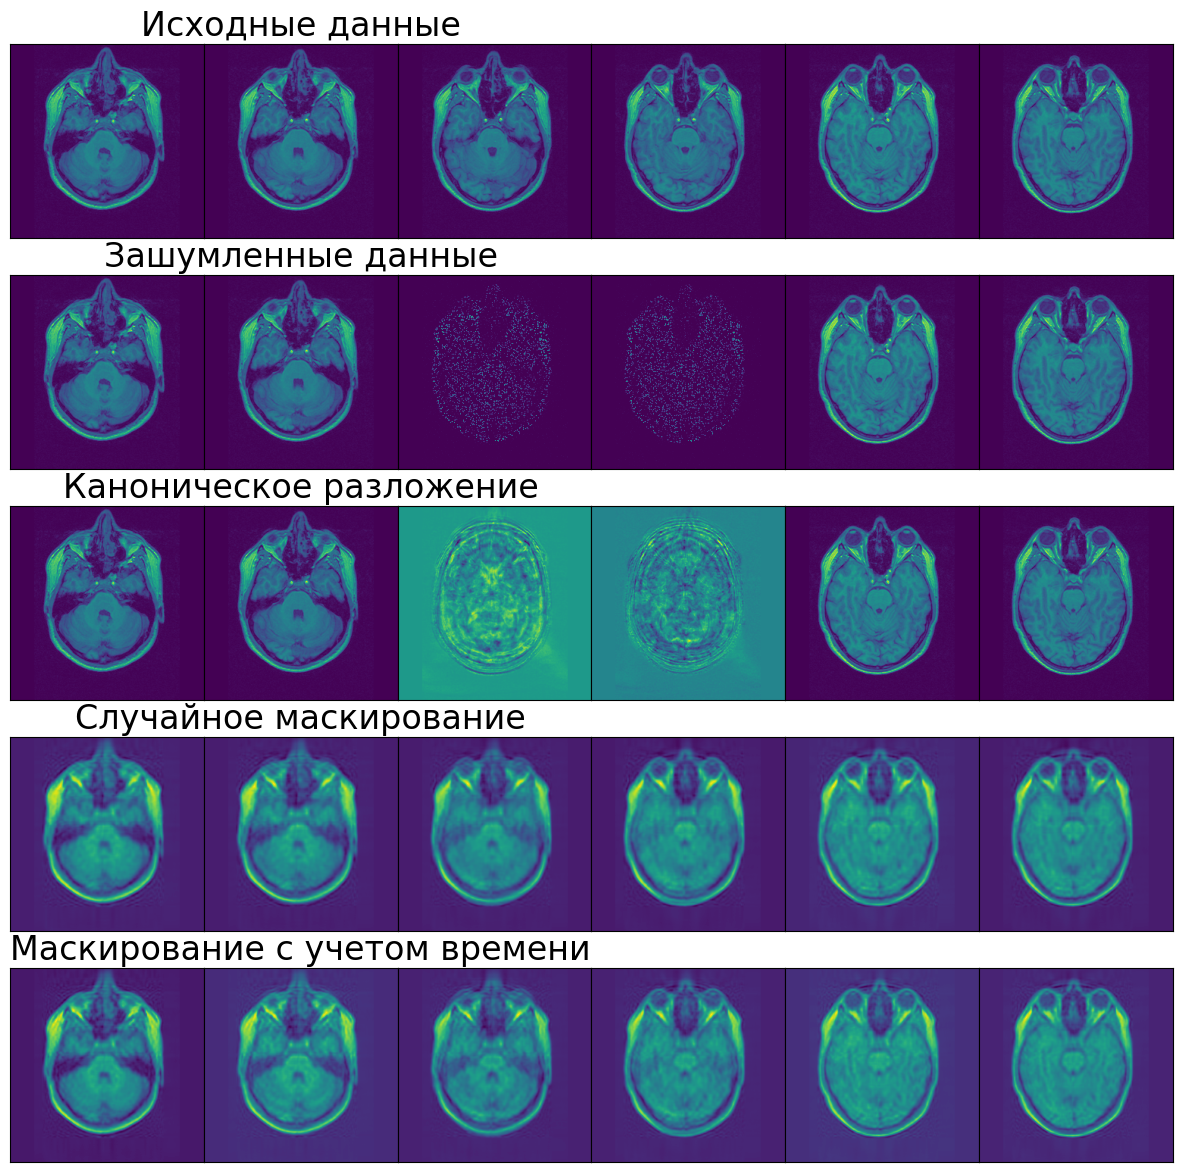

In [286]:
fig_nums = 6
tensor_to_draw = [
    data,
    dense_tensor,
    # dense_tensor_,
    # dense_tensor,
    tensor_hat_HaLRTC,
    # tensor_hat_LATC,
    # tensor_hat_TNN_DCT,
    # tensor_hat_TuckerTC,
    # tensor_hat,
    x_1234,
    x_123,
    
]
tensor_to_draw
# tensor_to_draw = [np.multiply(tnsr, data) for tnsr in tensor_to_draw]
name = ['Исходные данные', 'Зашумленные данные', 'Каноническое разложение', 'Случайное маскирование', 'Маскирование с учетом времени']
fig, ax = plt.subplots(len(tensor_to_draw), fig_nums, figsize=[int(2.5*fig_nums), 3*len(tensor_to_draw)])

for raw_num, tensor in enumerate(tensor_to_draw):
    n = 0
    for slice in range(11,11+fig_nums):
        ax[raw_num, n].imshow(tensor[:, :, slice], 'viridis')
        ax[raw_num, n].set_xticks([])
        ax[raw_num, n].set_yticks([])
        if n == 1:
            ax[raw_num, n].set_title(name[raw_num], fontdict = {'fontsize': 24})
            # print(name[raw_num]+f'  {np.linalg.norm(data[:,:,13:15]-tensor[:,:,13:15])**1/2}') 
            print(name[raw_num]+f'  {ssim(data[:,:,13],tensor[:,:,13], data_range=data[:,:,13].max() - data[:,:,13].min())}')
            
        n += 1
        
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()